<div id="colab_button">
  <h1>Data visualization</h1>
  <a target="_blank" href="https://colab.research.google.com/github/mithril-security/bastionlab/blob/v0.3.7/docs/docs/tutorials/visualization.ipynb"> 
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</div>
__________________________________________________________________________

Data visualization methods such as graphs and charts can be a great tool to help make data more accessible and tell the stories hidden in numbers. 

Our implementations of key visualization methods focus on privacy. We extract data only when it's truly necessary for the visualization function, and we perform remote aggregation before extracting data where possible. This works in addition to all the other safety benefits and features, such as data access policies.

In this tutorial, we'll introduce the **data visualization functions** available in BastionLab and see **how to use them** with our `RemoteLazyFrame` object.

## Pre-requisites
___________________________________________

### Installation and dataset

In order to run this notebook, we need to:
- Have [Python3.7](https://www.python.org/downloads/) (or greater) and [Python Pip](https://pypi.org/project/pip/) installed
- Install [BastionLab](https://bastionlab.readthedocs.io/en/latest/docs/getting-started/installation/)
- Download [the dataset](https://www.kaggle.com/competitions/titanic) we will be using in this tutorial.

We'll do so by running the code block below. 

>If you are running this notebook on your machine instead of [Google Colab](https://colab.research.google.com/github/mithril-security/bastionlab/blob/v0.3.6/docs/docs/tutorials/data_cleaning.ipynb), you can see our [Installation page](https://bastionlab.readthedocs.io/en/latest/docs/getting-started/installation/) to find the installation method that best suits your needs.

In [42]:
# pip packages
!pip install bastionlab
!pip install bastionlab_server

# download the dataset
!wget 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'

Obtaining file:///home/laura/bl5/client
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for bastionlab (pyproject.toml) ... done
  Created wheel for bastionlab: filename=bastionlab-0.3.7-0.editable-py3-none-any.whl size=1600 sha256=576a7ac0dc59018246dd69831c2dbd4d1022af48cfab66fac84b87625ebb3ab5
  Stored in directory: /tmp/pip-ephem-wheel-cache-21t3hx4y/wheels/57/25/ed/ef0c7974fbb68a253a27418d7a93849cb2965ff10400a0cdfd
Successfully built bastionlab
  Attempting uninstall: bastionlab
    Found existing installation: bastionlab 0.3.7
    Uninstalling bastionlab-0.3.7:
      Successfully uninstalled bastionlab-0.3.7


Our dataset is based on the Titanic dataset, one of the most popular datasets used for understanding machine learning which contains information relating to the passengers aboard the Titanic. 

### Launch and connect to the server

In [43]:
# launch bastionlab_server test package
import bastionlab_server

srv = bastionlab_server.start()

>*Note that the bastionlab_server package we install here was created for testing purposes. You can also install BastionLab server using our Docker image or from source (especially for non-test purposes). Check out our [Installation Tutorial](https://bastionlab.readthedocs.io/en/latest/docs/getting-started/installation/) for more details.*

In [44]:
# connect to the server
from bastionlab import Connection

connection = Connection("localhost")
client = connection.client

### Upload the dataframe to the server


We'll quickly upload the dataset to the server with an open safety policy, since setting up BastionLab is not the focus of this tutorial. It will allows us to demonstrate features without having to approve any data access requests. You can check out how to define a safe privacy policy [here](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/defining_policy_privacy/).

In [45]:
import polars as pl
from bastionlab.polars.policy import Policy, TrueRule, Log

df = pl.read_csv("titanic.csv")
policy = Policy(safe_zone=TrueRule(), unsafe_handling=Log(), savable=True)
rdf = client.polars.send_df(df, policy=policy)

rdf

FetchableLazyFrame(identifier=52d71911-55ad-4367-bd0d-f10b36f245fc)


<div class="admonition warning">
    <p class="admonition-title">Important!</p>
    <p class=""><b>This policy is not suitable for production.</b> Please note that we <i>only</i> use it for demonstration purposes, to avoid having to approve any data access requests in the tutorial. <br></p>
    </div><br>

Since we are using the classic Titanic dataset, let's list the columns to verify we got the right dataset and give you an idea of the data we will be handling in this tutorial.

In [46]:
rdf.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

## Histplot
_____________________________________________________________________

Now, let's take a look at the first of our data visualization options, `histplot`.

The `histplot()` function accepts `x` and `y` arguments, which are strings referring to a column name, plus a `bins` integer value, which is set to 10 by default. You must provide either an `x` or `y` argument. 

There is also two optional arguments:
- `colors`: A string defining a hexcode, a list of string hexcodes or a BastionLab palette name defining the color of the histplot.
- `ax`: Matplotlib axes to be used for plot- a new axes is generated if not supplied.

We also accept any `kwargs` arguments accepted by Matplolib's `bar` function, when you supply only an `X` or `Y` argument, or `imshow` function, when you supply both `X` and `Y` arguments (this is possible because we call these function internally once we have ran the relevant aggregated query and applied bins to our dataframe.) 

>Accepted options are listed in [Matplotlib's bar documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.bar.html#matplotlib.axes.Axes.bar) and [Matplotlib's imshow documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html).

Let's take a look at an example. Here, we create a histogram to show the number of passengers in each age category, with bins of 15.

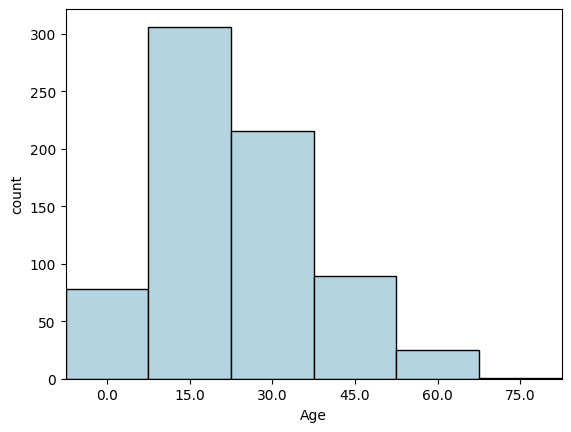

In [47]:
# import matploblib so we can display our graph with plt.show()
import matplotlib.pyplot as plt

rdf.histplot(x="Age", bins=15)

# use plt.show() to display returned matplotlib axes
plt.show()

If we provide an `x` and `y` value, this will internally make use of Seaborn's `heatmap` function.

>Accepted options are listed in [Seaborn's heatmap documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

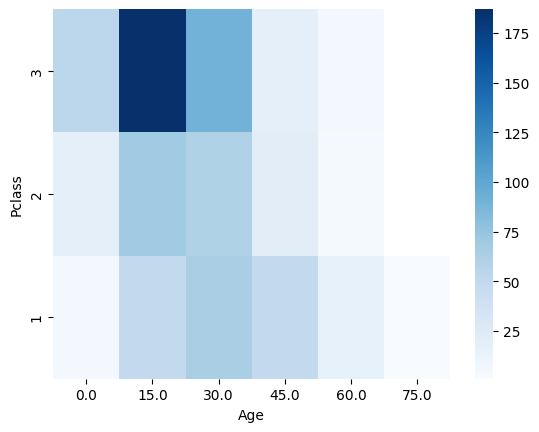

In [48]:
rdf.histplot(x="Age", y="Pclass", bins=15)
plt.show()

## Barplot
_____________________________________________________________________

Calculates heights of bars using aggregated queries and then uses `matplotlib's Axes.bar()` or `plt.barh()` function to plot a barplot.

The `estimator` value is set to `mean` by default, but can be changed to: `median`, `count`, `max`, `min`, `std` or `sum`.

Where `x` and `y` values are provided: `barplot()` calculates the `estimator` value of `y` per group in `x` and plots.
Where an `x` or `y` value is provided: `barplot()` calculates the overall `estimator` value of `x` or `y`

All arguments to barplot() are optional, but at least an `x` or a `y` value should be provided. 
The optional arguments are as follows:

- `x`: The name of column to be used for x axes
- `y`: The name of column to be used for y axes
- `hue`: The name of column for data to be grouped by for a grouped barplot
- `estimator`: A string representation of estimator to be used in aggregated query (mean by default). Options are: "mean", "median", "count", "max", "min", "std" and "sum"
- `vertical`: Option for vertical (True) or horizontal barplot (False). Set to True by default
- `title`: String title for plot
- `auto_label`: If True, labels for axes will be derived from x/y columns automatically. If false, x_label and y_label arguments used. Set to True by default
- `x_label`: Label for x axes if auto_label set to false
- `y_label`: Label for y axes if auto_label set to false
- `colors`: Colors for bars
- `ax`: Matplotlib axes to be used for plot- a new axes is generated if not supplied.


`barplot()` also forwards any additional `kwargs` arguments to Matplotlib's `Axes.bxp()` function which is called internally to plot our boxes:
>You can find those in [Matplotlib's Axes.bxp() documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.bxp.html). 

Here, we create a barplot to show the `mean` (default estimator) `fare` paid by passengers grouped by `class`:

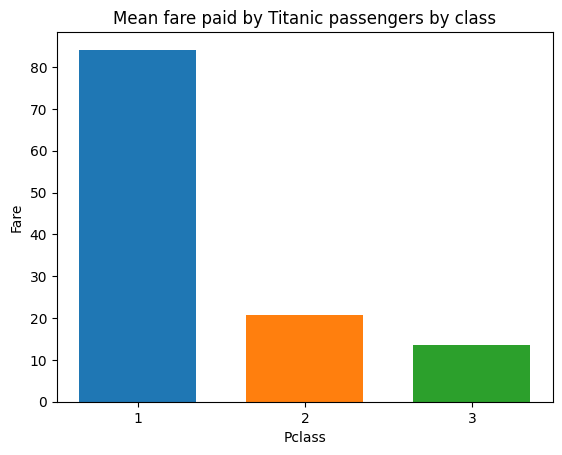

In [49]:
# Create barplot which shows the mean faire paid for by passengers by class
rdf.barplot(
    x="Pclass",
    y="Fare",
    width=0.7,
    title="Mean fare paid by Titanic passengers by class",
)
plt.show()

Now let's do another query to showcase a few of the options available.

We will get the `median` `Fare` values per `Pclass` and group the data by `Sex`.

To do this, we will set the `estimator` option to `median`, set the `hue` option to `Sex` and set the `vertical` option to False.

Finaly, we will set the `width` and `colors` options to customize our barplot further.

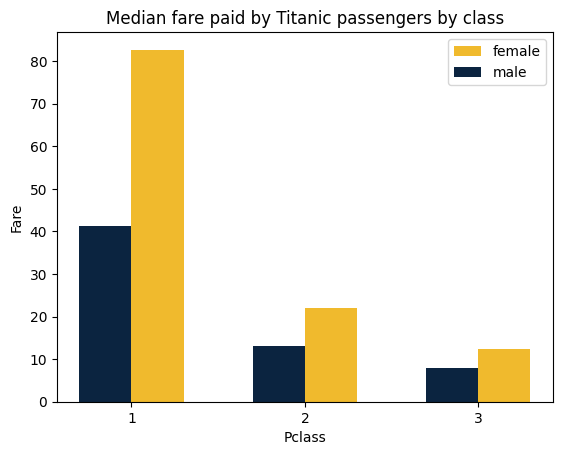

In [50]:
# Create barplot which shows the median faire paid for by passengers by class grouped by sex
rdf.barplot(
    x="Pclass",
    y="Fare",
    hue="Sex",
    estimator="median",
    width=0.3,
    title="Median fare paid by Titanic passengers by class",
    colors="mithril",
)
plt.show()

## Scatterplot
________________________________________________________________________________

The `scatterplot` function plot will display a scatter diagram based on `x` and `y` arguments given and can be used to look for correlations between these two columns. 

`scatterplot()` requires `x` and `y` string arguments referring to the name of the columns to be used for the x and y axes in the scatterplot.

There are then the following optional arguments:
- `hue`: The name of column for data to be grouped by (each group will be plotted in a different color)
- `ax`: Matplotlib axes to be used for plot- a new axes is generated if not supplied.
- `colors`: A list of colors or BastionLab palette name to be used for the plotting color(s).

It will first narrow down the `RemoteLazyFrame` to the necessary columns to make the function call, before calling Matplotlib's `scatter` function to plot your scatter graph.

This function also accepts the same `optional arguments` as Matplotlib's scatter function as `kwargs`.
> You can find those in [Matplolib's scatter documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html).

Let's take a look at a quick example where we create a scatterplot of the fare paid by age. We group data by gender, with female results plotted in blue and male results plotted in orange. We use Matplotlib's `marker` option to plot the data as small points.

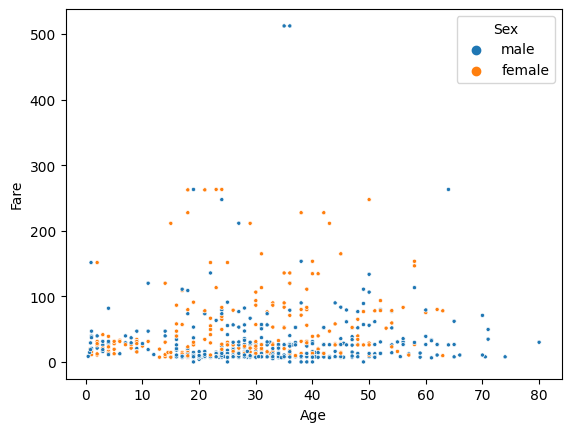

In [51]:
rdf.scatterplot("Age", "Fare", hue="Sex", marker=".")
plt.show()

## Lineplot
________________________________________________________________________________

The `lineplot` function filters our dataframe down to necessary columns only and then draws a line graph using Seaborn's `lineplot` function.

`lineplot()` requires `x` and `y` string arguments that refer to the names of columns to be used for the x and y axes. 

It also accepts `hue`, `size` and `string` arguments. The arguments are the names of the columns to be used as grouping variables which will produce lines with different
colors, widths and dashes and/or markers respectively. 

Additionally, lineplot accepts a `units` argument which is the name of a column to be used as a grouping variable identifying sampling units. Note that you must also set the `estimator` keyword to `None` if you wish to use the `units` argument.

Finally, the function also accepts the same `optional arguments` as Seaborn's `lineplot` function as `**kwargs`. 
>You can find those in [Seaborn's lineplot documentation](https://seaborn.pydata.org/generated/seaborn.lineplot.html).

Let's have a look at an example.


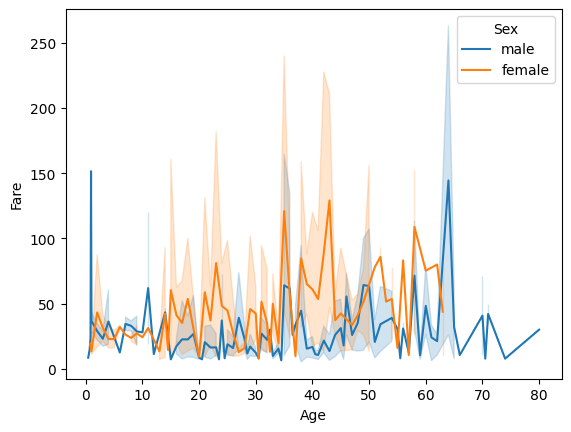

In [52]:
rdf.lineplot(x="Age", y="Fare", hue="Sex")

## Boxplot
________________________________________________________________________________

`Boxplot()` plots a boxplot by running aggregated queries to retrieve the necessary data and then working with matplotlib's `bxp` function to plot the data.

Boxplots tells us several things about data:

- The `min` value represented by the bottom-most `whisker` line
- The `max` value represented by the upper-most `whisker` line
- The `25th percentile` represented by the box's bottom line
- The `75th percentile` represented by the box's top line
- The `median` represented by an additional line running through the box.

Some boxplots also show additional `outliers` but we have not included outliers since they are *not private* by definition, and so, are likely to breach any aggregation-based security policy.

`boxplot()` has the following optional arguments:

- `x`: name of column to be used for the `x` axes. (There must be *at least* an `x` or a `y` argument supplied.)
- `y`: name of column to be used for the `y` axes. (There must be *at least* an `x` or a `y` argument supplied.)
- `colors`: color(s) or name of builtin BastionLab color palette to be used for boxes, provided as a string or list of strings.
- `vertical`: boolean option for vertical (`True`) or horizontal (`False`) orientation
- `ax`: matplotlib.axes to plot on. A new axes is created if none given.
- `widths`: boxes' widths
- `median_linestyle`: linestyle for median line
- `median_color`: color for median line 
- `median_linewidth`: boxes' widths
 
`boxplot` also forwards any additional `kwargs` arguments to Matplotlib's `Axes.bxp()` function which is called internally to plot our boxes:
>You can find those in [Matplotlib's Axes.bxp() documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.bxp.html). 

Let's take a look at an example using a single `y` argument, `fare`. This will show us the `min`, `max`, `25th percentile`, `75th percentile` and `median` fare paid on the Titanic. 

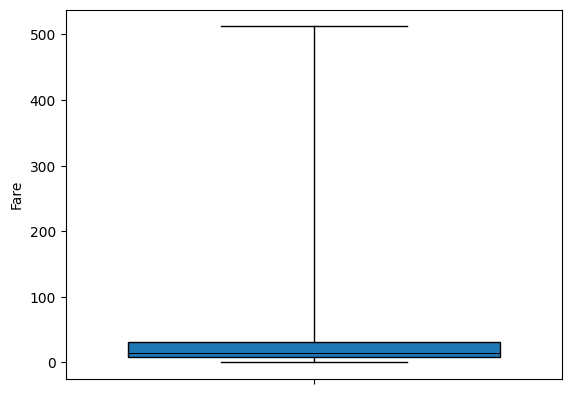

In [53]:
rdf.boxplot(y="Fare")

Ah, we see the plot is stretched out quite a lot by the large difference between the majority of values and the `max` value. 
We can counter this by clipping our `Fare` column to contain values only within a certain range.

Let's try that out now: we clip the data down to a range of 0-100 and then create a new single-axes boxplot of fares paid on the Titanic.

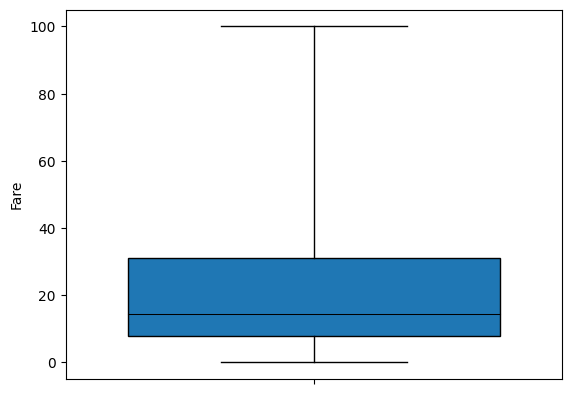

In [54]:
# clip data to include fare values from 0-100 to avoid stretched out plot
clipped = rdf.select(pl.col("Fare").clip(min_val=0, max_val=100))
# boxplot our clipped version of data
clipped.boxplot(y="Fare")

Next, let's take a look at an example using an `x` and `y` column. 
Here, the boxplot show the `min`, `max`, `25th percentile`, `75th percentile` and `median` fare paid on the Titanic per each `Pclass` group.

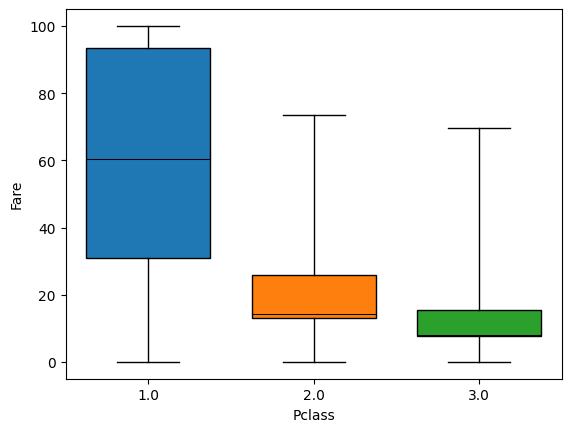

In [55]:
# Collect fare and Pclass data and clip data down to fares under 100
clipped = rdf.select([pl.col("Fare").clip(min_val=0, max_val=100), pl.col("Pclass")])
# create boxplot
clipped.boxplot(y="Fare", x="Pclass")

Finally, let's do the same plot again but with some of the additional options we have.

We set `vertical` to False, to view the data horizontally.

We set `colors` to BastionLab's builtin `light` palette. 

BastionLab has four builtin palettes: 

`standard`: 

![](../../assets/standard.png)

`light`: 

![](../../assets/light.png)

`ocean`:

![](../../assets/ocean.png)

`mithril`:

![](../../assets/mithril_2.png)

You can also apply your own colors by sending `boxplot` a lists of strings containing different hex codes!

Finally, we set `widths` to 0.2 to make our boxes more narrow.

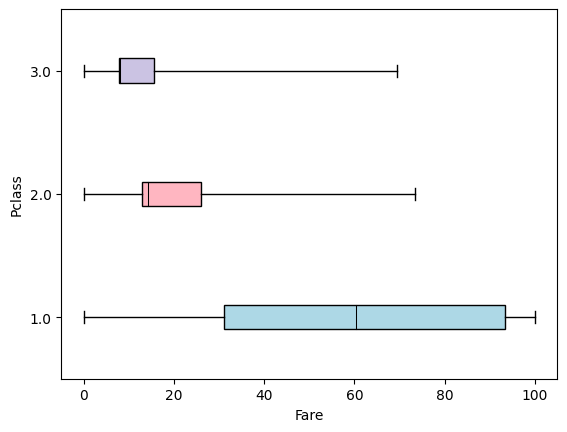

In [56]:
# create same boxplot as previously but with different aesthetic options
clipped.boxplot(y="Fare", x="Pclass", vertical=False, colors="light", widths=0.2)

## Pieplot
________________________________________________________________________________

The `pieplot` functions draws a pie chart where segment values are stored in one column and labels are provided. We calculate each individual cell in the column as a percentage of the sum of values in that column before calling Matplotlib's [pie function](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html).

This is particularly useful after running aggregated queries, which will become clear in the following example, but first, let's take a look at the arguments `pieplot()` takes:

- An mandatory `parts` string argument, which is the name of the column containing the values for each segment in the pie chart.
- A `Title` string argument.
- A `labels` argument, which is either the name of the column containing labels values, or a List[str] of the labels. In both cases, the order of the labels should follow the same order as the values in the `parts` column.
- An `ax` argument, which allows you to send your own matplotlib axis if required. Note that if you do this, the following `fig_kwargs` arguments will not be used.
- A `fig_kwargs` dictionary argument, which is where you can add any `kwargs` you wish to be forwarded onto `matplotlib.pyplot.subplots()` when creating the figure that this piechart will be displayed on.
- A `pie_labels` boolean value, which you can modify to `False` if you do not with to label the segments of your pie chart.
- A `key` boolean value, where you can specify if you want a color map key placed to the side of your pie chart.
- The `key_loc`, `key_title` and `key_bbox` options, where you can specify the location, title and bbox options for your color map key. These are forwarded on to matplotlib's legend function.

Now, let's take a look at an example of where we might use `pieplot`. We will run an aggregated query to get the number of deceased per passenger class on the Titanic.

We first filter the dataset to those who did not survive the Titanic, then we select all necessary columns and group data by Pclass, before we get a count of values per each class and sort the output by `Pclass`.

We can then call our `pieplot` function on this dataset specifying the "Survived" column as our `parts` argument, a title for our pie chart and the `"Class"` column to be used for labelling, to get our pie chart.

shape: (3, 2)
┌────────┬──────────┐
│ Pclass ┆ Survived │
│ ---    ┆ ---      │
│ i64    ┆ u32      │
╞════════╪══════════╡
│ 1      ┆ 80       │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 2      ┆ 97       │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 3      ┆ 372      │
└────────┴──────────┘


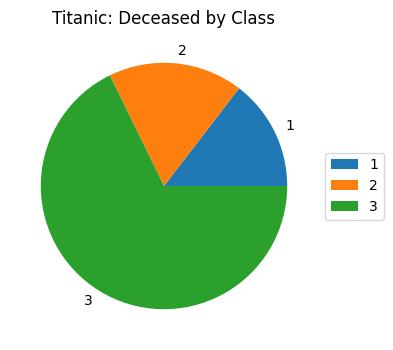

In [57]:
rdf_ex = (
    rdf.filter(pl.col("Survived") == 0)
    .select([pl.col("Survived"), pl.col("Pclass")])
    .groupby(pl.col("Pclass"))
    .agg(pl.col("Survived").count())
    .sort(pl.col("Pclass"))
)
print(rdf_ex.collect().fetch())
rdf_ex.pieplot(parts="Survived", title="Titanic: Deceased by Class", labels="Pclass")

## Facet grid plots
_______________________________________________________________________________________________________________

The `facet` function lets you create a grid of plots that accepts a `col` and `row` argument. You can then call the `histplot`, `scatterplot` or `curveplot` functions to decide how you want to plot your data in the columns and rows of the grid. 

For example, if you have a Facet with a row value of `"Pclass"` and you call `my_facet.histplot(x="Age", bins=15)`, you will see three histplots: one showing the age of passengers in class 1, one for passengers in class 2 and the final one for class 3.

Before we continue any further, let's see the code for this example:

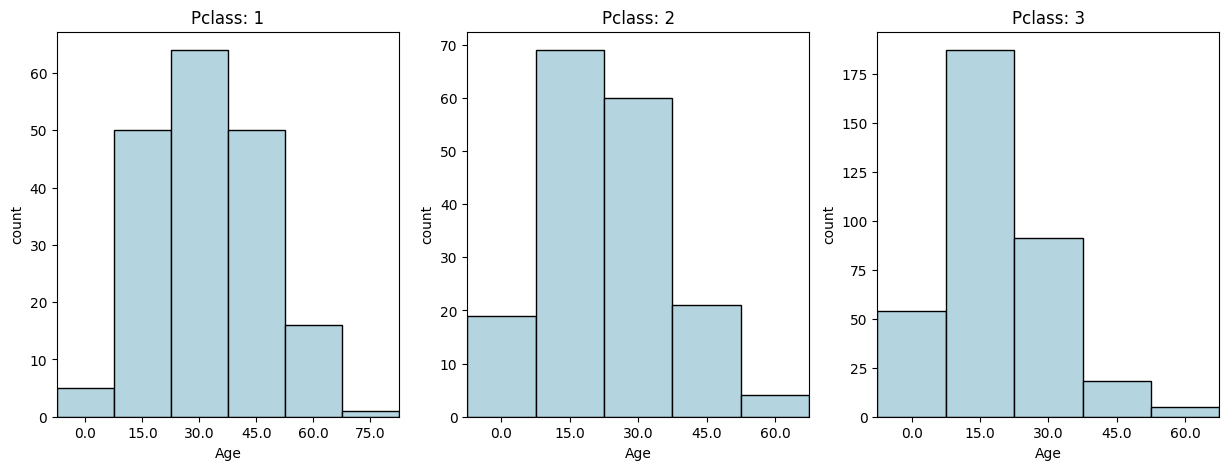

In [58]:
my_facet = rdf.facet(col="Pclass")
my_facet.histplot(x="Age", bins=15)
plt.show()

Now that we have seen an example with a row, let's add a column! We will also specify the `figsize`, the size of the figure we want for our grid.

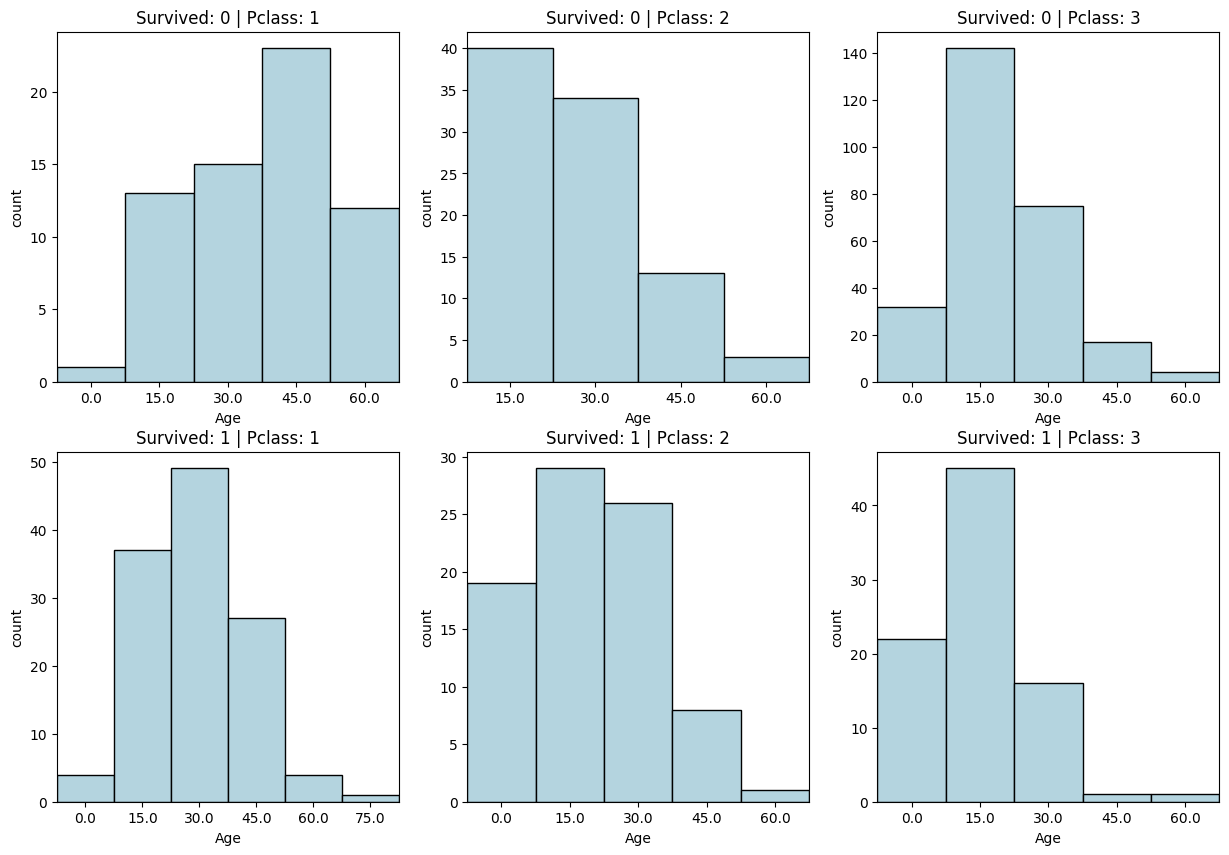

In [59]:
new_facet = rdf.facet(col="Pclass", row="Survived", figsize=(15, 10))
new_facet.histplot(x="Age", bins=15)
plt.show()

The grid now splits results into all the possible combinations of the column and row values.

As previously mentioned, this feature works with all the visualization functions except for the pieplot function. 

>**Important note**: the `hue`, `size` `string` and `units` keywords cannot be used for `lineplot` when using `facet`. 

Here's a facet grid with `barplot()`, for example:


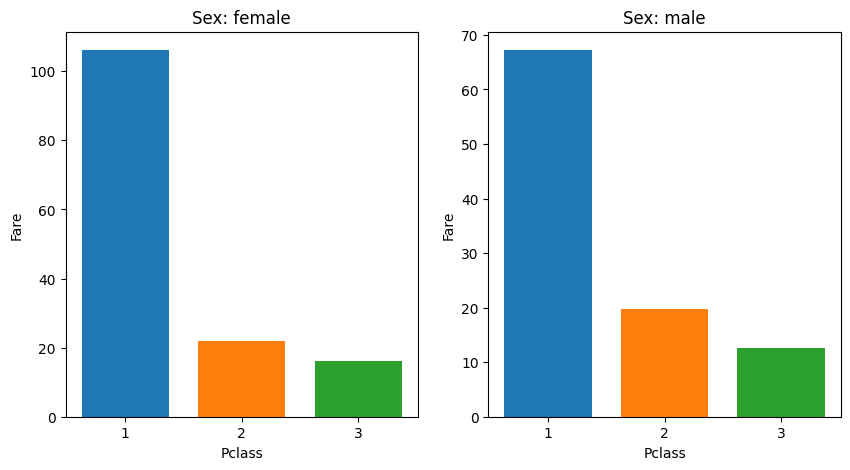

In [60]:
my_facet = rdf.facet(col="Sex")
my_facet.barplot(x="Pclass", y="Fare")
plt.show()

That's it! As our last step, we'll close the connection to the server.

In [61]:
# connection.close()
# bastionlab_server.stop(srv)